In [1]:
import numpy as np
from PIL import Image, ImageFilter
from timeit import default_timer as timer
from moviepy.editor import VideoFileClip
import matplotlib.pyplot as plt
import subprocess as sp
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

In [2]:
meet_bars, meet_nps = [], []

def load():
    global meet_bars, meet_nps
    images = ["meet_bar1.png", "meet_bar2.png", "meet_bar3.png", "meet_bar4.png"]

    for image in images:
        img = Image.open(image)
        meet_bars.append(img)
        meet_nps.append(np.array(img))

def detect_vi(img=None):
    global meet_bars, meet_nps
    
    diff_min = 100000
    min_idx = 0
    
    #subtrai as imagens originais das imagens de referência (barras meet)
    #se o erro for mínimo, então a barra do meet foi identificada
    #armazena o índice da barra identificada, para analisar situações de tela dividida
    for i in range(0,len(meet_nps)):
        cut_im = cut_frame(img)
        #diff = meet_nps[i] - cut_im
        diff = mean_squared_error(meet_nps[i], cut_im)
        
        if(np.average(diff) < diff_min):
            min_idx = i
            diff_min = np.average(diff)
    
    #se o limiar de identificação for menor que 40 (aceita pequenas variações)
    #então o software ofusca (blur) a imagem
    if(diff_min <= 30):
        #print('blur image')
        
        #meia tela
        width_end = 960
        if(min_idx == 2):
            width_ini = 490
        else:
            width_ini = 0
        
        pil_im = Image.fromarray(img[:,width_ini:width_end,:])
        filter_im = pil_im.filter(ImageFilter.GaussianBlur(radius = 5)) #(ImageFilter.BLUR)
        
        #meia tela
        if(min_idx == 2):
            pil_ini = Image.fromarray(img[:,:width_ini,:])
            filter_im = np.concatenate((pil_ini, filter_im), axis=1)
        
        out_im = np.concatenate((filter_im , img[:,width_end:, :]), axis=1)
        return out_im 
    else:
        #print('not blur image', diff_min)
        return img

def plot_frame(frame):
    plt.figure(figsize=(20, 12))
    plt.imshow(frame)
    plt.grid(False)
    plt.show()
    
def cut_frame(frame):
    #return frame[590:625,430:930,:]
    return frame[590:625,780:930,:]

def calcula_diffs(frame_ini=0, frame_end=100, idx_meet_np = 0):
    global meet_bars, meet_nps
    
    for i in range(frame_ini, frame_end):
        frame = clip1.get_frame(i)
        diff = meet_nps[idx_meet_np] - cut_frame(frame)
        print(i, np.average(diff))

In [3]:
#carrega as barras do google meet, usada para identificação
load()

In [4]:
#carrega video a ser editado
#video_path = 'ajg-sadx-pga.mp4'
video_path = 'nuh-wejh-wnb.mp4'
print(video_path)

clip1 = VideoFileClip(video_path)
tempo_vi = int(clip1.duration)
print('Tempo vídeo:', tempo_vi)

nuh-wejh-wnb.mp4
Tempo vídeo: 5820


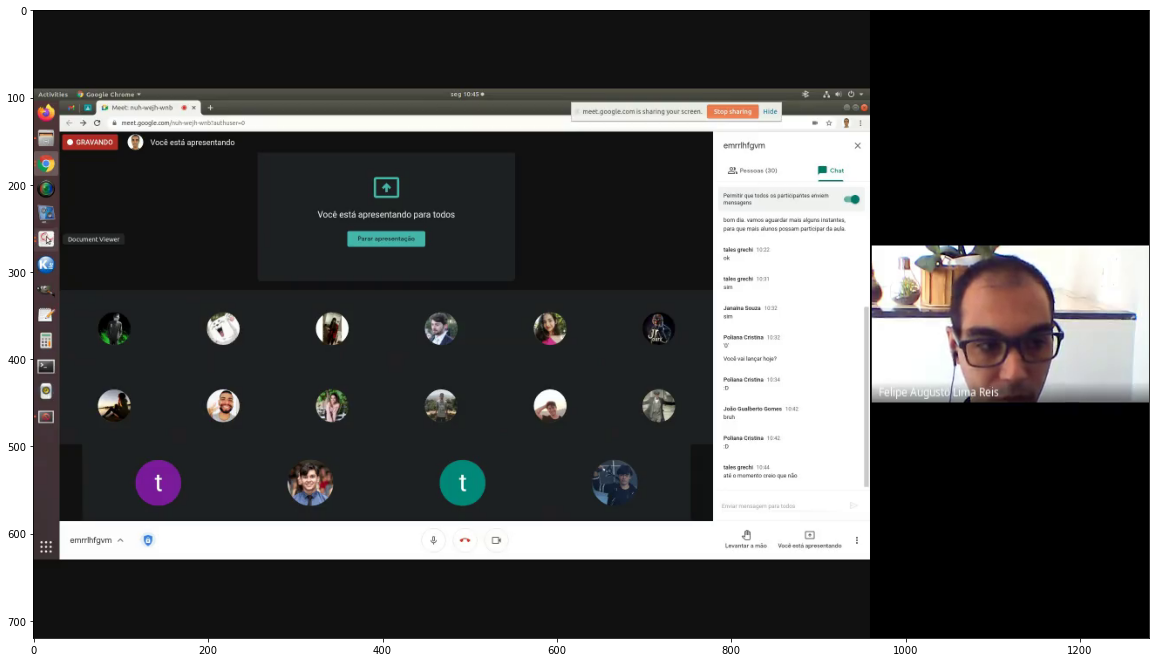

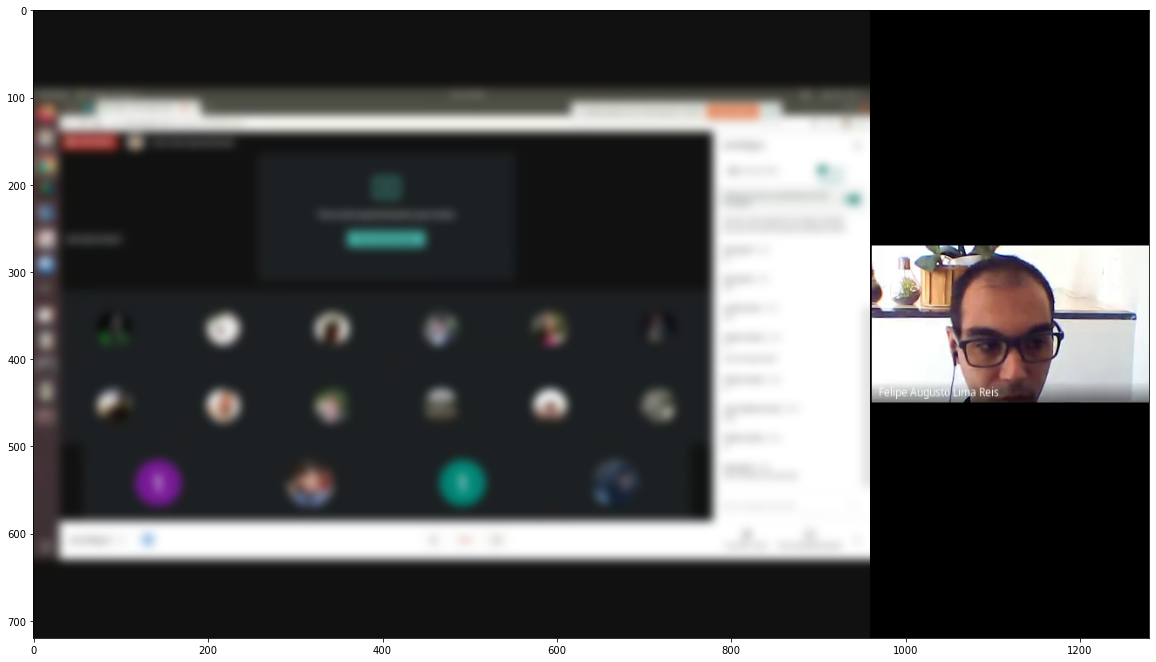

In [5]:
#exibe uma amostra da tela, para identificação prévia e testes iniciais
frame = clip1.get_frame(83.15) #3, 19, 64, 83.15, 200, 2857
output = detect_vi(img=frame)
plot_frame(frame)
plot_frame(output)

pil_im = Image.fromarray(cut_frame(frame))
pil_im.save('meet_bar4.png')

In [ ]:
moviepy_videofile = 'blur_{}'.format(video_path)
moviepy_audiofile = 'blur_{}m4a'.format(video_path[:-3])

#gera o vídeo
#blur_clip = clip1.subclip(64,150).fl_image(detect_vi)
blur_clip = clip1.fl_image(detect_vi)
blur_clip.write_videofile(moviepy_videofile, 
                          codec='libx264', 
                          audio_codec='aac', 
                          temp_audiofile=moviepy_audiofile, 
                          remove_temp=False
)

chunk:   0%|          | 173/128346 [00:00<01:14, 1725.03it/s, now=None]

Moviepy - Building video blur_nuh-wejh-wnb.mp4.
MoviePy - Writing audio in blur_nuh-wejh-wnb.m4a


t:   0%|          | 4/139696 [00:00<1:02:49, 37.06it/s, now=None]         

MoviePy - Done.
Moviepy - Writing video blur_nuh-wejh-wnb.mp4



t:  36%|███▌      | 49997/139696 [07:19<06:36, 226.50it/s, now=None] 

In [ ]:
#adiciona audio usando ffmpeg
command = ['ffmpeg',
           '-y', #approve output file overwite
           '-i', str(moviepy_videofile),
           '-i', str(moviepy_audiofile),
           '-c:v', 'copy',
           '-c:a', 'copy',
           '-shortest', 
           str('final_{}'.format(moviepy_videofile)) ]

#with open(ffmpeg_log, 'w') as f:
process = sp.Popen(command)